In [1]:
using JLD
using KrylovMethods
using PyPlot
using DivSigGrad
using jInv.InverseSolve
using jInv.Mesh
using jInv.LinearSolvers
using jInv.ForwardShare
using jInv.Utils
using jInv.Vis

# jInv.jl: PDE Constrained Optimization / Parameter Estimation

#### Zheng Wang

I will show a simple 2D example for the PDE constrained optimization Julia package `jInv.jl`. Briefly, the package `DivSigGrad.jl` is used to solve the elliptic PDE shown below. It is linked to a gradient based optimization method implemented in `jInv.jl` to solve an inverse problem.


## Elliptic Partial Differential Equation (PDE)
### $ \nabla \cdot \big(\sigma \, \nabla P\big) = f $

The elliptic PDE is shown above. $\sigma$ is referred to as the conductivity field, $P$ the potential field, and $f$ the forcing. Generally, $\sigma$, $f$ and boundary conditions are provided, and numerical methods (for example finite element methods) are used to find $P$. Using $(\sigma, f, \ldots)$ to determine $P$ is sometimes called solving the **forward problem**.

## Inverse Problem

To solve an **inverse problem** we are instead given (an empirically measured) output $P$. An optimization routine is called to find the best input $\sigma$ that matches this output. During the optimization, the best guess for $\sigma$ is updated and the PDE must be solved repeatedly. For this problem, we assume the boundary conditions and the forcing are known and fixed. The following notes summarize the task.

Given:
- Fixed sources $f$
- Function to solve PDE:  $(\sigma, f) \rightarrow P$
- Measured data $P$


Want to find:
- Conductivity field $\sigma$

## Future Work

This is a first step towards a final project where multiple solution to the **deterministic** inverse problem computed by `jInv.jl` is used within a sampling scheme to solve the **stochastic** inverse problem. The solution to this approach will be compared with the solution from another Julia package that directly solves the stochastic inverse problem, i.e. `Stan.jl`.


## Define the domain and mesh
We define a square domain by specifying its bounds. Using `jInv.jl` we create a `Mesh` object that contains the location of all the nodes of a regular grid (among other useful things). 

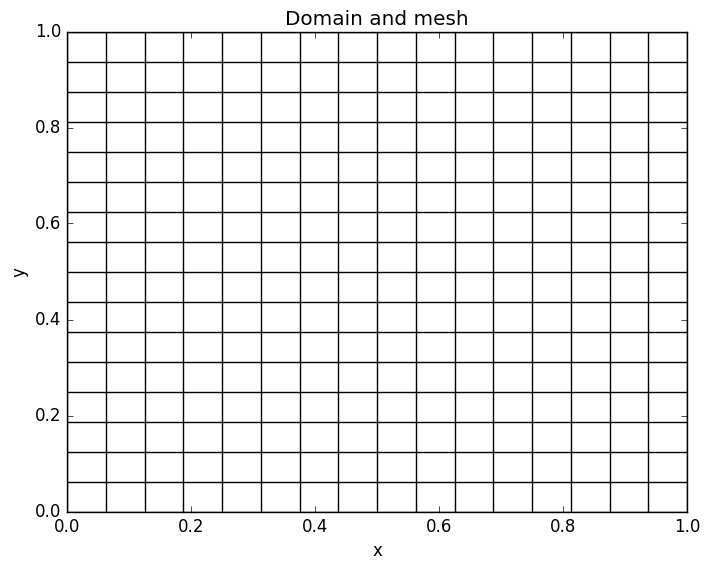

PyObject <matplotlib.text.Text object at 0x319e0d690>

In [2]:
domain    = [0.0 1.0 0.0 1.0]; # boundaries for the 2D domain
n         = [64 64]; # number of elements for each dimension
Mesh      = getRegularMesh(domain,n);
Mesh_plot = getRegularMesh(domain,n+1); # used for plotting fields defined on nodes

# Plot the domain and mesh
plotGrid(getNodalGrid(Mesh),Mesh,spacing=[4 4],color="k")
xlabel("x"); ylabel("y"); title("Domain and mesh")

## Set up sources

We set up the sources $f(x,y)$. This is created in a matrix and stored in a vector (convention used in `jInv.jl`). We also describe the measurement operator that takes $P$ to our measurements. Let's use the entire potential field as a measurement so the measurement operator is the identity matrix.

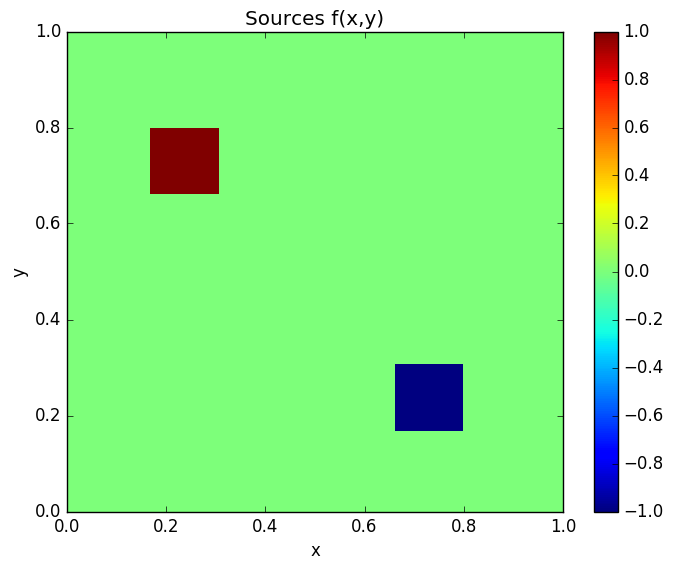

PyObject <matplotlib.text.Text object at 0x319ff9c10>

In [3]:
# Create the source using a matrix
Sources    = spzeros(Float64, n[1]+1, n[2]+1);
for i = div(n[1]*3,16):div(n[1]*5,16)
    for j = div(n[2]*11,16):div(n[2]*13,16)
        Sources[i,j] = 1;
    end
end
for i = div(n[1]*11,16):div(n[1]*13,16)
    for j = div(n[2]*3,16):div(n[2]*5,16)
        Sources[i,j] = -1;
    end
end
Sources = vec(Sources[:])

# Define the measurement as the entire potential field
Receivers  = speye(Float64, prod(n+1)); 

# Plot the sources
viewImage2D(Sources,Mesh_plot);
colorbar(); xlabel("x"); ylabel("y"); title("Sources f(x,y)")

## Solve the PDE 
### $ \nabla \cdot \big(\sigma \, \nabla P\big) = f $

To solve the PDE, `DivSigGrad.jl` creates a linear system from the Mesh, $\sigma$, $f$ and boundary conditions. We will use the iterative Conjugate Gradient algorithm in `KrylovMethods,jl` to solve the linear system.

In [4]:
# Set up the function that solves the PDE
PCGsolver(A,b;M=M,tol=1e-14,maxIter=200,out=-1) = KrylovMethods.cg(A,b;M=M,tol=1e-14,maxIter=200,out=-1)
A_inv           = getIterativeSolver(PCGsolver)
Forward_problem = DivSigGradParam(Mesh, Sources, Receivers, [], A_inv);

#### Solve PDE using a uniform conductivity field $\sigma(x,y) = 0.01$:
This plot shows the potential field $P$ when we set $\sigma = 0.01$ on the entire domain.

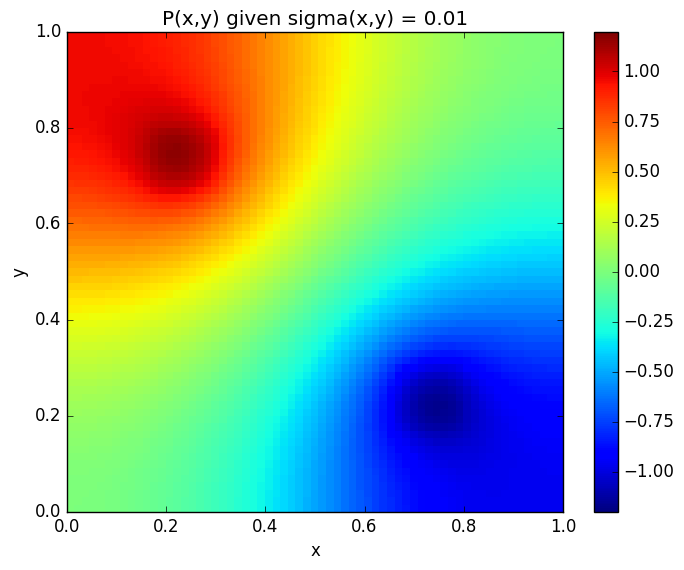

PyObject <matplotlib.text.Text object at 0x106af8610>

In [5]:
σ_ref      = 0.01*ones(prod(n));
d_obs_ref, = getData(σ_ref, Forward_problem);

#plotting
viewImage2D(d_obs_ref,Mesh_plot)
colorbar(); clim(-1.2,1.2); 
xlabel("x"); ylabel("y"); title("P(x,y) given sigma(x,y) = 0.01")

#### Solve PDE using an unknown conductivity field $\sigma(x,y) = ???$:
This plot shows $P$ when we set $\sigma$ to something mysterious.

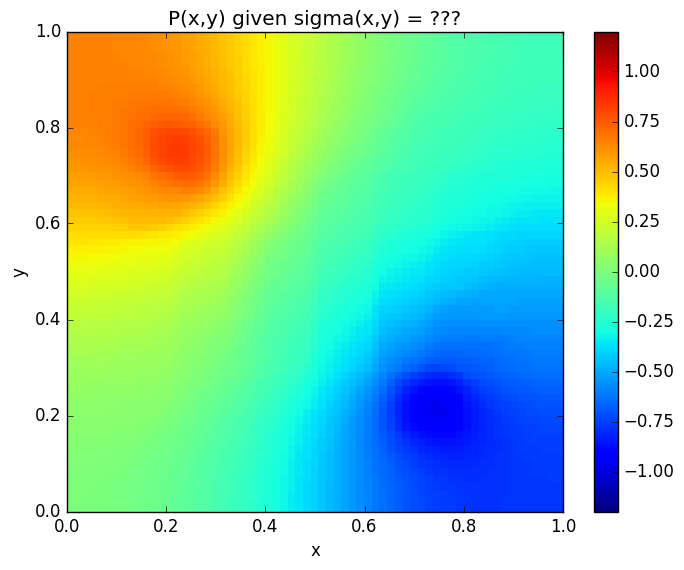

PyObject <matplotlib.text.Text object at 0x31d79eb10>

In [6]:
σ       = load("example.jld","sigma");  #some unknown matrix
σ       = vec(σ[:]);
d_obs,  = getData(σ, Forward_problem);

#plotting
viewImage2D(d_obs,Mesh_plot)
colorbar(); clim(-1.2,1.2); 
xlabel("x"); ylabel("y"); title("P(x,y) given sigma(x,y) = ???")

#### Plot the difference
There is clearly a difference between the two potential fields $P$. So our mysterious field is probably not $0.01$ everywhere. We'll try to find out what it is in the next section.

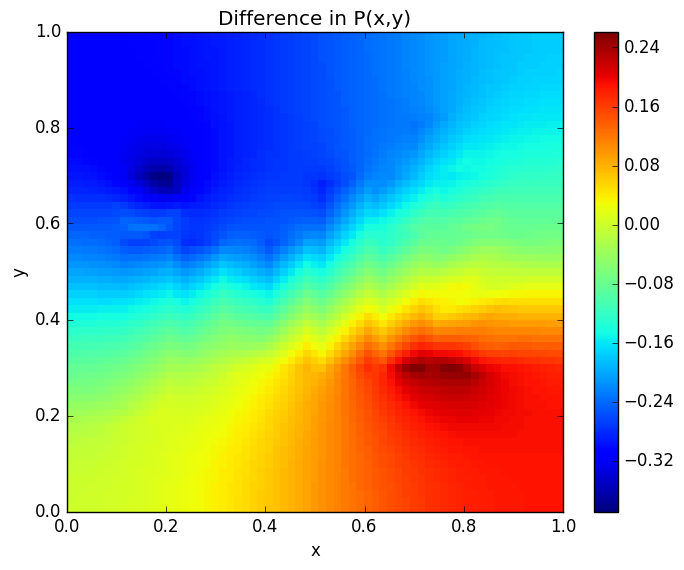

PyObject <matplotlib.text.Text object at 0x31d8e99d0>

In [7]:
viewImage2D(d_obs- d_obs_ref,Mesh_plot)
colorbar(); #clim(-0.4,0.4)
xlabel("x"); ylabel("y"); title("Difference in P(x,y)")

## Setup the optimization
In order to solve the inverse problem through optimization, we need to specify an objective function. The objective function we will use is:
### $ \mathcal{J}(\sigma) =  \|P(\sigma) - d_{obs}\|^2 + \alpha \, \mathcal{R}(\sigma) $
- $d_{obs}$ is the given measurement data
- $P(\sigma)$ is the potential field found from solving the PDE using $\sigma$
- $\mathcal{R}$ is a regularization function that penalizes gradients
- $\alpha$ is a regularization parameter

We minimize this objective function using a gradient based method implemented in `jInv.jl`. The first term of the objective function tries to keep the output of the potential close to what we observe. The second term (the regularization) prevents the solution from being too noisy (having large gradients or oscillating wildly). $\alpha$ called the regularization parameter is tuneable parameter to balances the tradeoff between matching our observations and having a smooth (nice) solution.

#### Transform the $\sigma$ variable
Since negative $\sigma$ is not physical, we can use a variable transformation by optimizing over $\log \sigma$ to ensure that $\sigma$ always is positive.

In [8]:
# optimize on log-conductivity to ensure it is always positive
m_ref         = log(σ_ref);   

Set up the misfit function $\| \cdot \|^2$ with weights:

In [9]:
weights       = ones(size(d_obs))/mean(vec(abs(d_obs-d_obs_ref)));                #  used to get misfit parameter
misfit_params = getMisfitParam(Forward_problem, weights, d_obs, SSDFun, identityMod);

Set up the regularization function $\mathcal{R}$:

In [10]:
# configure regularization
α             = 1e-6;
reg_params    = [1e-6; ones(sum(Mesh.nf))];
reg_fun(m,m_ref,Mesh) = wdiffusionReg(m,m_ref,Mesh,C = reg_params);

Set up optimization settings: maximum iterations, stopping criteria, variable bounds

In [11]:
# configuer optimization
HesPrec     = getSSORRegularizationPreconditioner(1.0,1e-4,200);
cgit       	= 200; 
pcgTol     	= 1e-2;
maxIter    	= 50;
minUpdate 	= 1e-3;
boundsLow  	= (log(0.01)-4).*ones(size(m_ref));
boundsHigh 	= (log(0.01)+4).*ones(size(m_ref));
maxStep		= 0.4*maximum(boundsHigh-boundsLow);

Combine everything together

In [12]:
Inverse_problem = getInverseParam(Mesh,expMod,reg_fun,α,vec(m_ref),
         boundsLow,boundsHigh,maxStep=maxStep,pcgMaxIter=cgit,pcgTol=pcgTol,
         minUpdate=minUpdate, maxIter = maxIter, HesPrec = HesPrec);

## Optimize!

In [13]:
mc,Dc,flag = projGNCG(copy(m_ref[:]),Inverse_problem,misfit_params);
flag

i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	2.86e+03	0.00e+00	1.00e-06	1.00e+00	  0
   .1	1.35e+02	1.68e-06			4.71e-02
  2.0	1.35e+02	1.68e-06	1.00e-06	4.71e-02	  0
   .1	4.97e+00	8.04e-06			1.74e-03
  3.0	4.97e+00	8.04e-06	1.00e-06	1.74e-03	  0
   .1	1.61e+01	7.83e-05			5.62e-03
   .2	9.83e-01	2.81e-05			3.44e-04
  4.0	9.83e-01	2.81e-05	1.00e-06	3.44e-04	  0
   .1	2.43e+00	1.30e-04			8.49e-04
   .2	5.43e-01	6.47e-05			1.90e-04
  5.0	5.43e-01	6.47e-05	1.00e-06	1.90e-04	  0
   .1	8.35e-02	9.33e-05			2.92e-05
  6.0	8.35e-02	9.33e-05	1.00e-06	2.92e-05	  0
   .1	1.31e-01	1.67e-04			4.58e-05
   .2	4.59e-02	1.22e-04			1.61e-05
  7.0	4.59e-02	1.22e-04	1.00e-06	1.61e-05	  0
   .1	1.24e-02	1.61e-04			4.39e-06
  8.0	1.24e-02	1.61e-04	1.00e-06	4.39e-06	  0
   .1	1.33e-02	1.95e-04			4.72e-06
   .2	7.08e-03	1.75e-04			2.53e-06
  9.0	7.08e-03	1.75e-04	1.00e-06	2.53e-06	  0
   .1	3.39e-03	1.76e-04			1.25e-06
 10.0	3.39e-03	1.76e-04	1.00e-06	1.25e-06	  0
   .1	1.30e-02	2.13e-04			4.61e-06


1

## Show results for the optimized $\sigma$
#### Solve PDE using the optimized conductivity field $\sigma(x,y)$

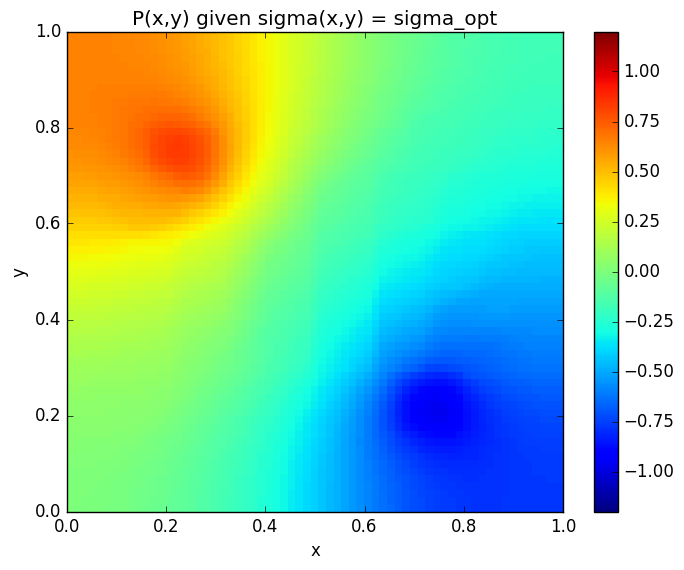

PyObject <matplotlib.text.Text object at 0x31dbe5610>

In [14]:
σ_opt       = exp(mc);
d_obs_opt,  = getData(σ_opt, Forward_problem);
viewImage2D(d_obs_opt,Mesh_plot)
colorbar(); clim(-1.2,1.2)
xlabel("x"); ylabel("y"); title("P(x,y) given sigma(x,y) = sigma_opt")

#### Plot the difference

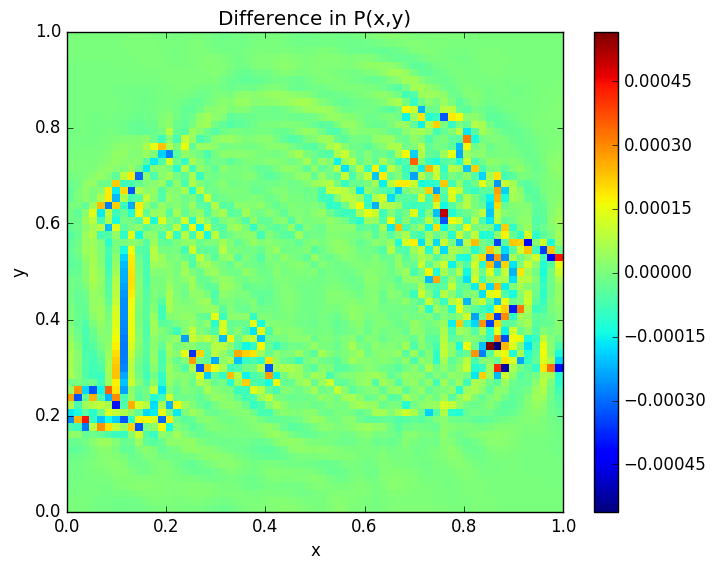

PyObject <matplotlib.text.Text object at 0x106953c50>

In [15]:
viewImage2D((d_obs- d_obs_opt),Mesh_plot)
colorbar(); #clim(-0.4,0.4)
xlabel("x"); ylabel("y"); title("Difference in P(x,y)")

#### Plot the optimized conductivity field

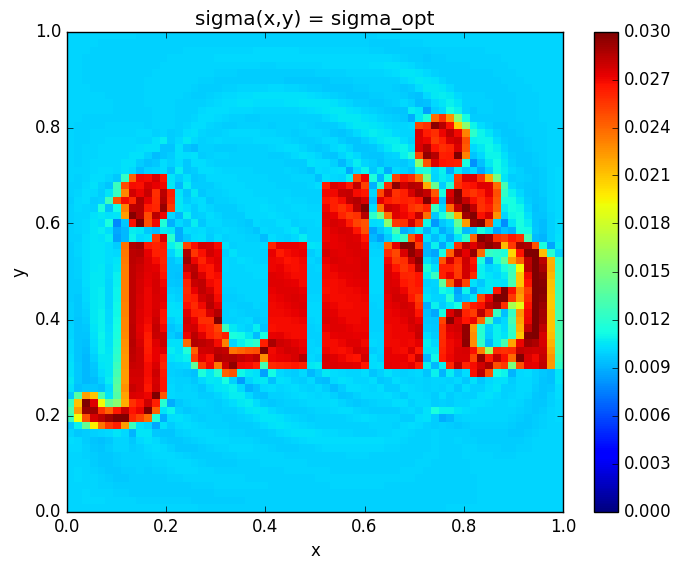

PyObject <matplotlib.text.Text object at 0x31e6e9990>

In [16]:
viewImage2D(σ_opt,Mesh);
colorbar(); clim(0,0.03)
xlabel("x"); ylabel("y"); title("sigma(x,y) = sigma_opt")

#### Plot the true unknown conductivity field

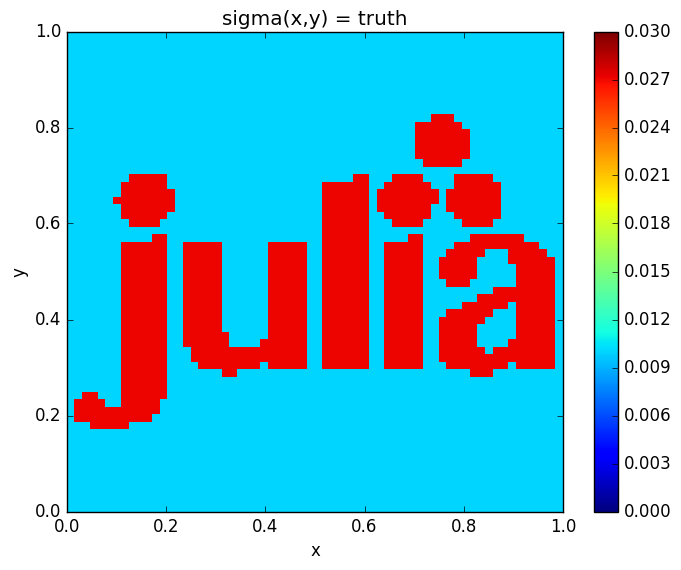

PyObject <matplotlib.text.Text object at 0x31ea3b890>

In [17]:
viewImage2D(σ,Mesh);
colorbar(); clim(0,0.03)
xlabel("x"); ylabel("y"); title("sigma(x,y) = truth")